In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [7]:
df = pd.read_csv("cleaned_heart_disease_data.csv")
X = df.drop(columns=['num'])
df['num'] = np.where(df['num']>0,1,0)
y = df['num']

In [8]:
X = df.drop(columns=['num','chol','trestbps'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### GridSearchCV hyperparameter tuning

Baseline SVM Accuracy: 0.9344
Best parameters found:
classifier__C: 1
classifier__gamma: scale
classifier__kernel: rbf

Test Score (GridSearch) = 0.9344


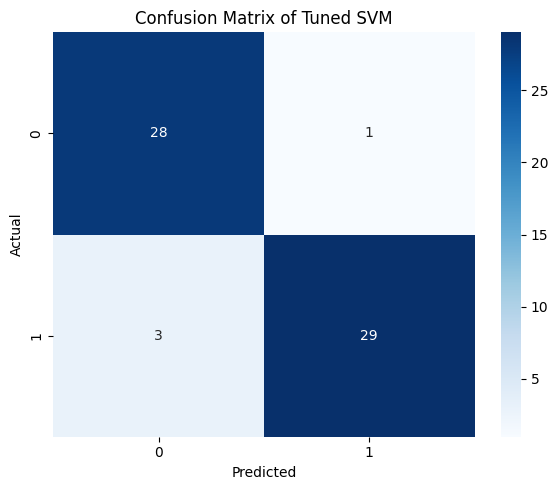

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61


Final model saved as Models/final_model.pkl


In [14]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

seed = 42

# Scale the data for baseline SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================
# Baseline SVM (with scaling, no tuning)
# =========================
baseline_svm = SVC(random_state=seed, probability=True)
baseline_svm.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_svm.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline SVM Accuracy: {baseline_acc:.4f}")

# =========================
# Tuned SVM + GridSearchCV
# =========================
pipeCv = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=seed))
])

params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

best_model = GridSearchCV(
    estimator=pipeCv,
    param_grid=params,
    scoring='accuracy',
    cv=cv,
    verbose=0,
    n_jobs=-1,
    refit=True
)

best_model.fit(X_train, y_train)

# Predict and evaluate tuned model
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

print("Best parameters found:")
for key, value in best_model.best_params_.items():
    print(f"{key}: {value}")
print(f"\nTest Score (GridSearch) = {test_score:.4f}")

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Tuned SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

# =========================
# Save final tuned model
# =========================
filename = "Models/final_model.pkl"
pickle.dump(best_model, open(filename, "wb"))
print(f"\nFinal model saved as {filename}")


### RandomizedSearchCV hyperparameter tuning 


Baseline SVM Accuracy: 0.9344
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:
classifier__C: 0.30584494295802445
classifier__gamma: auto
classifier__kernel: rbf

Test Score (RandomizedSearch) = 0.9180


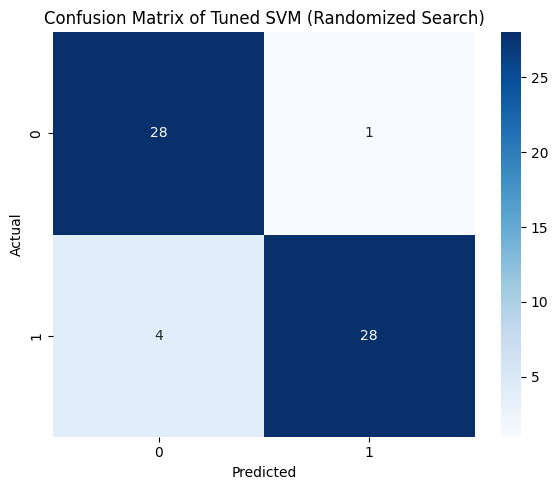

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       0.97      0.88      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61


Final retrained model accuracy on test set: 0.9180


In [15]:
# Train baseline SVM on pre-scaled data
baseline_svm = SVC(random_state=42, probability=True)
baseline_svm.fit(X_train_scaled, y_train)

# Predict and evaluate baseline
y_pred_baseline = baseline_svm.predict(X_test_scaled)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline SVM Accuracy: {baseline_acc:.4f}")

# Define pipeline without scaler (already scaled)
pipe = Pipeline([
    ('classifier', SVC(probability=True))
])

# Parameter distribution for RandomizedSearch
params_dist = {
    'classifier__C': uniform(0.1, 10),
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Cross-validation strategy
seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params_dist,
    n_iter=20,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=seed
)

# Fit randomized search on training data
random_search.fit(X_train_scaled, y_train)

# Predict and evaluate tuned model
y_pred = random_search.predict(X_test_scaled)
test_score = random_search.score(X_test_scaled, y_test)

# Print best hyperparameters and test score
print("Best parameters found:")
for key, value in random_search.best_params_.items():
    print(f"{key}: {value}")

print(f"\nTest Score (RandomizedSearch) = {test_score:.4f}")

# Confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix of Tuned SVM (Randomized Search)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

# Retrain best model on full training data (optional but recommended)
best_final_svm = random_search.best_estimator_
best_final_svm.fit(X_train_scaled, y_train)
final_pred = best_final_svm.predict(X_test_scaled)
final_acc = accuracy_score(y_test, final_pred)
print(f"\nFinal retrained model accuracy on test set: {final_acc:.4f}")
